# Comparing ASE/LSE with SVD/Spectral 
- badges: true
- toc: true
- comments: true
- categories: [Ullah, graspologic]
- hide: false
- search_exclude: false
- author: Kareef Ullah

In [5]:
import numpy as np
import timeit

from scipy.sparse import identity
from graspologic.inference import latent_position_test
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspologic.simulations import er_np, sbm, rdpg
from graspologic.utils import symmetrize
from graspologic.plot import heatmap, pairplot
from graspologic.align import OrthogonalProcrustes

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sknetwork.data import erdos_renyi, painters, movie_actor
from sknetwork.embedding import Spectral, SVD
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from IPython.display import SVG

# Simulation 1: ASE vs SVD

1. n_verts = [100, 500, 1000, 10000]
2. Generate an nx1 2D numpy array of latent positions of uniform distribution between 0.1 and 1
3. Divide each column by the array by the column's frobenius norm
4. Generate an RDPG from the 2D array
5. Perform ASE (n_components=1, check LCC=false) and SVD (n_componnets=1) on the RDPG  
6. Save the runtimes for each embedding method using the timeit.default_timer() method
7. From the generated latent positions of ASE, divide each column by the column's frobenius norm
8. Align the latent positions of ASE with the true latent positions using orthogonal procrustes
9. Save the frobenius norm of the aligned difference (true @ Q - ASE)
10. Repeat steps 7-9 using SVD instead of ASE
11. Repeat steps 2-10 for 15 trials per n in n_verts
12. Plot stripplots for times vs n_verts for ASE and SVD
13. Plot stripplots for frobenius norms of aligned differece of true and embedding latent positions vs n_verts for ASE and SVD

In [4]:
n_verts = [100, 500, 1000, 10000]
total_verts = []
time_ASE = []
time_SVD = []
norms_ASE = []
norms_SVD = []

In [5]:
for n in n_verts:
    for _ in range(15):
        
        total_verts.append(n)
        X = np.random.uniform(low=0.1, high=1, size=(n, 1))
        norm = np.linalg.norm(X, axis=0)
        X = X/norm
        A = rdpg(X)
        
        #get time for running ASE
        start_time = timeit.default_timer()
        ase = AdjacencySpectralEmbed(n_components=1, check_lcc=False)
        X1 = ase.fit_transform(A)
        norm1 = np.linalg.norm(X1, axis=0)
        X1 = X1/norm1
        elapsed_ASE = timeit.default_timer() - start_time
        time_ASE.append(elapsed_ASE)
        
        #get norm of X@Q-X1
        aligner_OP1 = OrthogonalProcrustes()
        X_prime_OP1 = aligner_OP1.fit_transform(X, X1)
        Q1 = aligner_OP1.Q_
        norm_ASE = np.linalg.norm(X@Q1-X1, ord='fro')
        norms_ASE.append(norm_ASE)
        
        #get time for running SVD
        start_time = timeit.default_timer()
        svd = SVD(1)
        X2 = svd.fit_transform(A)
        norm2 = np.linalg.norm(X2, axis=0)
        X2 = X2/norm2
        elapsed_SVD = timeit.default_timer() - start_time
        time_SVD.append(elapsed_SVD)
        
        #get norm of X@Q-X2
        aligner_OP2 = OrthogonalProcrustes()
        X_prime_OP2 = aligner_OP2.fit_transform(X, X2)
        Q2 = aligner_OP2.Q_
        norm_SVD = np.linalg.norm(X@Q2-X2, ord='fro')
        norms_SVD.append(norm_SVD)
        
        print(n)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


Note: When using too few vertices (ex: n=10), get an error at the line X_prime_OP1 = aligner_OP1.fit_transform(X, X1): Input contains NaN, infinity or a value too large for dtype('float64'). When using too large vertices (ex: n=100000), kernel dies.

In [6]:
time_ASE_dict = {"time_ASE": time_ASE, "n_verts": total_verts}
df_time_ASE = pd.DataFrame(data = time_ASE_dict)

In [7]:
norms_ASE_dict = {"norms_ASE": norms_ASE, "n_verts": total_verts}
df_norms_ASE = pd.DataFrame(data = norms_ASE_dict)

In [8]:
time_SVD_dict = {"time_SVD": time_SVD, "n_verts": total_verts}
df_time_SVD = pd.DataFrame(data = time_SVD_dict)

In [9]:
norms_SVD_dict = {"norms_SVD": norms_SVD, "n_verts": total_verts}
df_norms_SVD = pd.DataFrame(data = norms_SVD_dict)

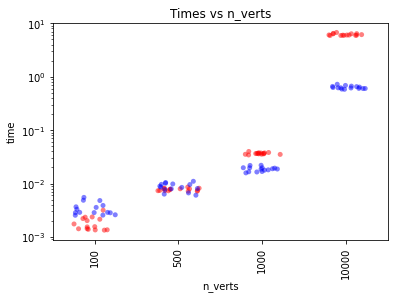

In [10]:
ax1 = sns.stripplot(data=df_time_ASE,
    x="n_verts",
    y="time_ASE",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='red'
)

ax2 = sns.stripplot(data=df_time_SVD,
    x="n_verts",
    y="time_SVD",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='blue'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('time')
plt.title("Times vs n_verts")

plt.savefig('timeASESVD_vs_n_verts.png')

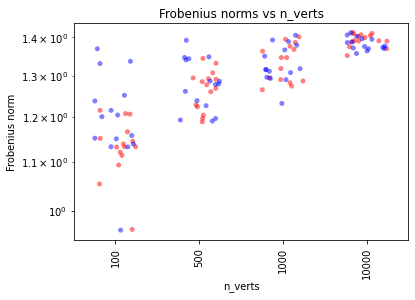

In [11]:
ax1 = sns.stripplot(data=df_norms_ASE,
    x="n_verts",
    y="norms_ASE",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='red'
)

ax2 = sns.stripplot(data=df_norms_SVD,
    x="n_verts",
    y="norms_SVD",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='blue'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('Frobenius norm')
plt.title("Frobenius norms vs n_verts")

plt.savefig('normsASESVD_vs_n_verts.png')

# Simulation 2: LSE vs Spectral

1. n_verts = [10, 100, 500, 1000]
2. Generate an nx1 2D numpy array of latent positions of uniform distribution between 0.1 and 1
3. Divide each column by the array by the column's frobenius norm
4. Generate an RDPG from the 2D array
5. Perform LSE (n_components=1, check LCC=false) and Specral (n_components=1) on the RDPG
6. Save the runtimes for each embedding method using the timeit.default_timer() method
7. From the generated latent positions of LSE, divide each column by the column's frobenius norm
8. Align the latent positions of LSE with the true latent positions using orthogonal procrustes
9. Save the frobenius norm of the aligned difference (true @ Q - LSE)
10. Repeat steps 7-9 using Spectral instead of LSE
11. Repeat steps 2-10 for 15 trials per n in n_verts
12. Plot stripplots for times vs n_verts for LSE and Spectral
13. Plot stripplots for frobenius norms of aligned differece of true and embedding latent positions vs n_verts for LSE and Spectral

In [8]:
n_verts = [10, 100, 500, 1000]
total_verts = []
time_LSE = []
time_Spectral = []
norms_LSE = []
norms_Spectral = []

In [9]:
for n in n_verts:
    for _ in range(15):
        
        total_verts.append(n)
        X = np.random.uniform(low=0.1, high=1, size=(n, 1))
        norm = np.linalg.norm(X, axis=0)
        X = X/norm
        A = rdpg(X)
        
        #get time for running LSE
        start_time = timeit.default_timer()
        lse = LaplacianSpectralEmbed(n_components=1, check_lcc=False)
        X1 = lse.fit_transform(A)
        norm1 = np.linalg.norm(X1, axis=0)
        X1 = X1/norm1
        elapsed_LSE = timeit.default_timer() - start_time
        time_LSE.append(elapsed_LSE)
        
        #get norm of X@Q-X1
        aligner_OP1 = OrthogonalProcrustes()
        X_prime_OP1 = aligner_OP1.fit_transform(X, X1)
        Q1 = aligner_OP1.Q_
        norm_LSE = np.linalg.norm(X@Q1-X1, ord='fro')
        norms_LSE.append(norm_LSE)
        
        #get time for running Spectral
        start_time = timeit.default_timer()
        spectral = Spectral(1)
        X2 = spectral.fit_transform(A)
        norm2 = np.linalg.norm(X2, axis=0)
        X2 = X2/norm1
        elapsed_Spectral = timeit.default_timer() - start_time
        time_Spectral.append(elapsed_Spectral)
        
        #get norm of X@Q-X2
        aligner_OP2 = OrthogonalProcrustes()
        X_prime_OP2 = aligner_OP2.fit_transform(X, X2)
        Q2 = aligner_OP2.Q_
        norm_Spectral = np.linalg.norm(X@Q2-X2, ord='fro')
        norms_Spectral.append(norm_LSE)
        
        print(n)

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


Note: After 5th iteration of n=10000, error at line X2 = spectral.fit_transform(A): ArpackNoConvergence: ARPACK error -1: No convergence (100001 iterations, 1/2 eigenvectors converged)

In [10]:
print(total_verts)
print(norms_LSE)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[0.7753758281658086, 0.9473443771334656, 0.9344647246243025, 1.061920820599386, 1.2103451825378049, 1.3938527694189549, 0.8191018985619293, 1.1008647863720427, 0.7704056906529018, 1.368078427146916, 0.8644471308562368, 1.0163986253191664, 0.6944606481630345, 1.337556153180136, 0.6934269502293677, 1.2322667087633148, 1.367259330729229, 1.1654524858888349, 1.219439897455196, 1.3178472918140998, 1.3945948834887731, 1.3633581686257026, 1.329203298996723, 1.4096103956537356, 1.3683374002780757, 1.3847460456815823, 1.3362046958202378, 1.2939630411763183, 1.3524610504275516, 1.1678177000779602, 1.3242579792438511, 1.3553971876860798, 1.3540729630832982, 1.401456970180328, 1.2855919000919098, 1.360

In [11]:
time_LSE_dict = {"time_LSE": time_LSE, "n_verts": total_verts}
df_time_LSE = pd.DataFrame(data = time_LSE_dict)

In [12]:
norms_LSE_dict = {"norms_LSE": norms_LSE, "n_verts": total_verts}
df_norms_LSE = pd.DataFrame(data = norms_LSE_dict)

In [13]:
time_Spectral_dict = {"time_Spectral": time_Spectral, "n_verts": total_verts}
df_time_Spectral = pd.DataFrame(data = time_Spectral_dict)

In [14]:
norms_Spectral_dict = {"norms_Spectral": norms_Spectral, "n_verts": total_verts}
df_norms_Spectral = pd.DataFrame(data = norms_Spectral_dict)

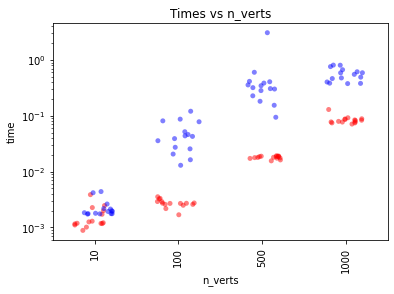

In [15]:
ax1 = sns.stripplot(data=df_time_LSE,
    x="n_verts",
    y="time_LSE",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='red'
)

ax2 = sns.stripplot(data=df_time_Spectral,
    x="n_verts",
    y="time_Spectral",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='blue'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('time')
plt.title("Times vs n_verts")

plt.savefig('timeLSESpectral_vs_n_verts.png')

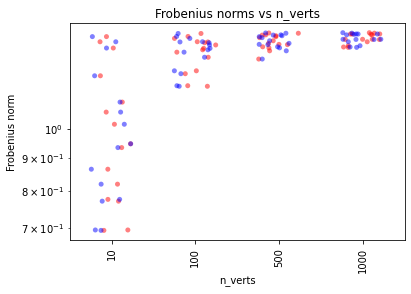

In [16]:
ax1 = sns.stripplot(data=df_norms_LSE,
    x="n_verts",
    y="norms_LSE",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='red'
)

ax2 = sns.stripplot(data=df_norms_Spectral,
    x="n_verts",
    y="norms_Spectral",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='blue'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('Frobenius norm')
plt.title("Frobenius norms vs n_verts")

plt.savefig('normsLSESpectral_vs_n_verts.png')